In [2]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

# Time Series
from prophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
print('All libraries imported successfully!')

All libraries imported successfully!


Data Loading 

In [11]:
# Load the data with tab delimiter
df = pd.read_csv('Silver_Price_Dataset.csv', sep='\t')
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%y')
df.set_index('Date', inplace=True)

# Drop Volume if it's all NaN
if 'Volume' in df.columns and df['Volume'].isnull().all():
    df.drop('Volume', axis=1, inplace=True)

print(f'Date Range: {df.index.min().date()} to {df.index.max().date()}')
print(f'Total Trading Days: {len(df):,}')
print(f'Total Years: {(df.index.max() - df.index.min()).days / 365:.1f} years')
df.head()

Date Range: 2016-01-19 to 2026-01-15
Total Trading Days: 2,513
Total Years: 10.0 years


,Price,Close,High,Low,Open
Date,,,,,
2016-01-19,14.110,14.110,14.065,14.065,3
2016-01-20,14.147,14.147,14.147,14.147,1
2016-01-21,14.083,14.083,14.083,14.083,2
2016-01-22,14.043,14.290,14.043,14.290,7
2016-01-25,14.240,14.240,14.095,14.095,8


In [12]:
# Dataset Info
print('Dataset Information:')
print(df.info())
print('\nStatistical Summary:')
df.describe().round(2)

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2513 entries, 2016-01-19 to 2026-01-15
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   2513 non-null   float64
 1   Close   2513 non-null   float64
 2   High    2513 non-null   float64
 3   Low     2513 non-null   float64
 4   Open    2513 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.8 KB
None

Statistical Summary:


,Price,Close,High,Low,Open
count,2513.00,2513.00,2513.00,2513.00,2513.00
mean,22.81,22.98,22.65,22.81,1777.77
std,8.85,9.00,8.67,8.82,10141.05
min,11.73,12.20,11.73,12.07,0.00
25%,16.83,16.91,16.76,16.84,10.00
50%,21.40,21.59,21.07,21.33,49.00
75%,25.51,25.72,25.27,25.51,177.00
max,91.88,93.00,88.71,90.82,131415.00


In [13]:
# Check for missing values
missing = df.isnull().sum()
print('Missing Values Analysis:')
print(missing)
print(f'\nMissing value percentage: {(missing.sum() / len(df) * 100):.2f}%')

Missing Values Analysis:
Price    0
Close    0
High     0
Low      0
Open     0
dtype: int64

Missing value percentage: 0.00%


Exploratory Data Analysis(EDA)

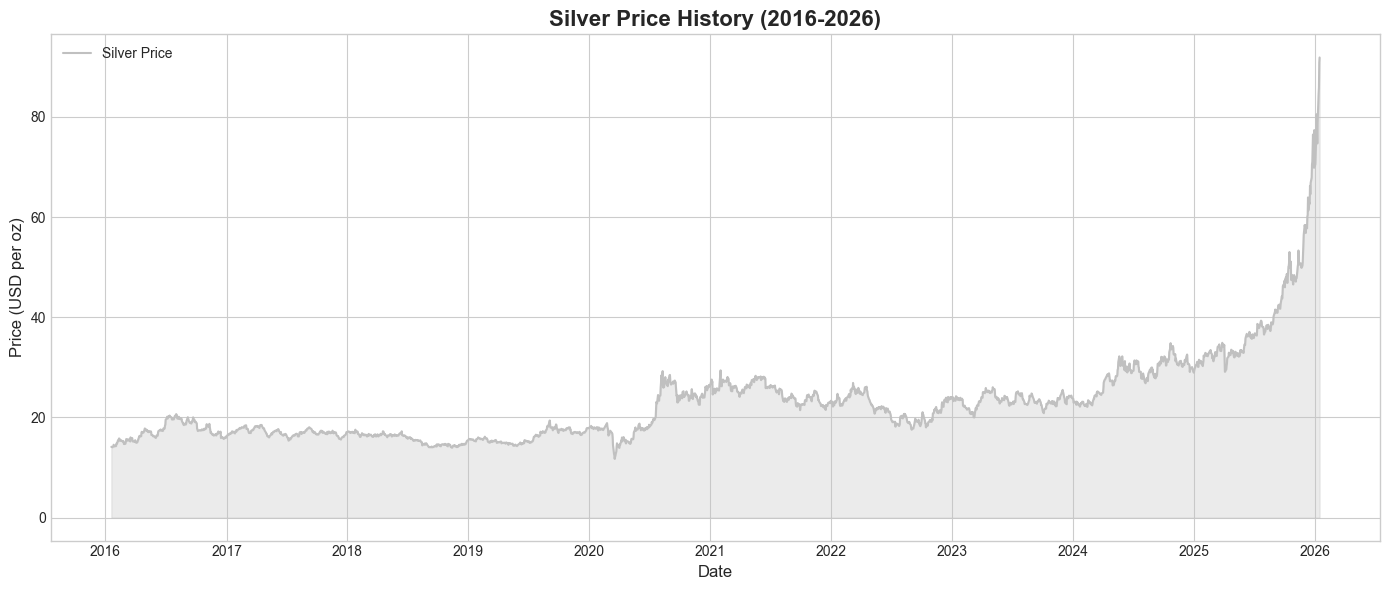

In [14]:
# Silver Price Over Time
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['Price'], color='#C0C0C0', linewidth=1.5, label='Silver Price')
ax.fill_between(df.index, df['Price'], alpha=0.3, color='silver')
ax.set_title('Silver Price History (2016-2026)', fontsize=16, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Price (USD per oz)', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

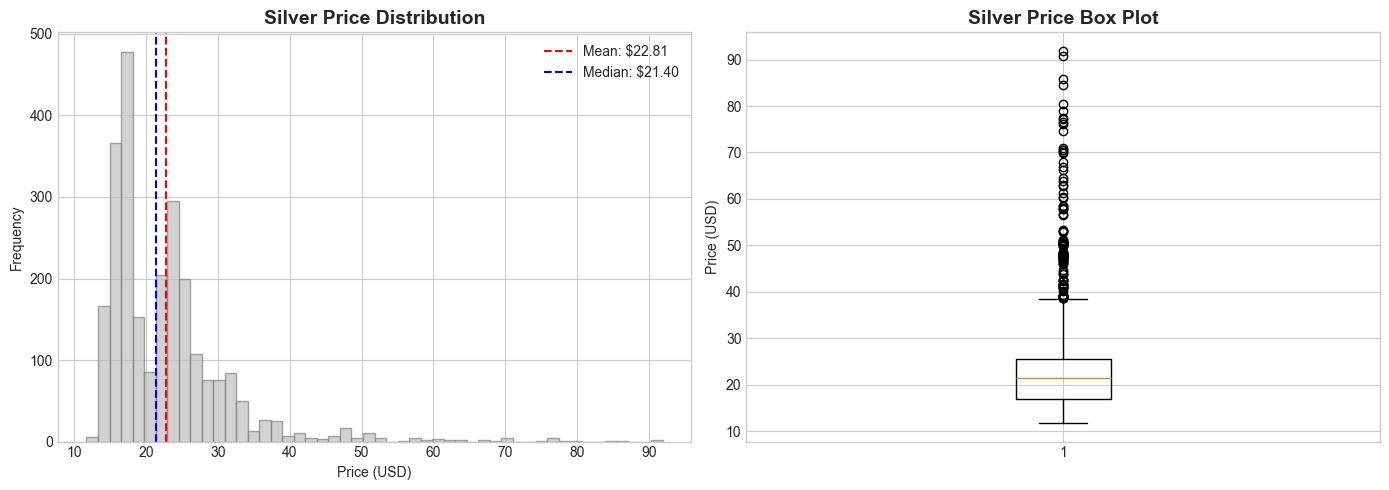

In [15]:
# Price Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(df['Price'], bins=50, color='silver', edgecolor='gray', alpha=0.7)
axes[0].axvline(df['Price'].mean(), color='red', linestyle='--', label=f'Mean: ${df["Price"].mean():.2f}')
axes[0].axvline(df['Price'].median(), color='blue', linestyle='--', label=f'Median: ${df["Price"].median():.2f}')
axes[0].set_title('Silver Price Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Price (USD)')
axes[0].set_ylabel('Frequency')
axes[0].legend()

# Box Plot
axes[1].boxplot(df['Price'].dropna(), vert=True)
axes[1].set_title('Silver Price Box Plot', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Price (USD)')

plt.tight_layout()
plt.show()

In [16]:
# Yearly Analysis
df['Year'] = df.index.year
yearly_stats = df.groupby('Year')['Price'].agg(['mean', 'min', 'max', 'std']).round(2)
yearly_stats.columns = ['Avg Price', 'Min Price', 'Max Price', 'Volatility']
print('Yearly Silver Price Statistics:')
yearly_stats

Yearly Silver Price Statistics:


,Avg Price,Min Price,Max Price,Volatility
Year,,,,
2016,17.27,14.04,20.67,1.73
2017,17.02,15.37,18.49,0.67
2018,15.65,13.95,17.55,1.04
2019,16.16,14.28,19.39,1.19
2020,20.65,11.73,29.25,4.42
2021,25.14,21.46,29.40,1.78
2022,21.76,17.55,26.89,2.30
2023,23.39,20.00,26.03,1.20
2024,28.30,22.10,34.83,3.26


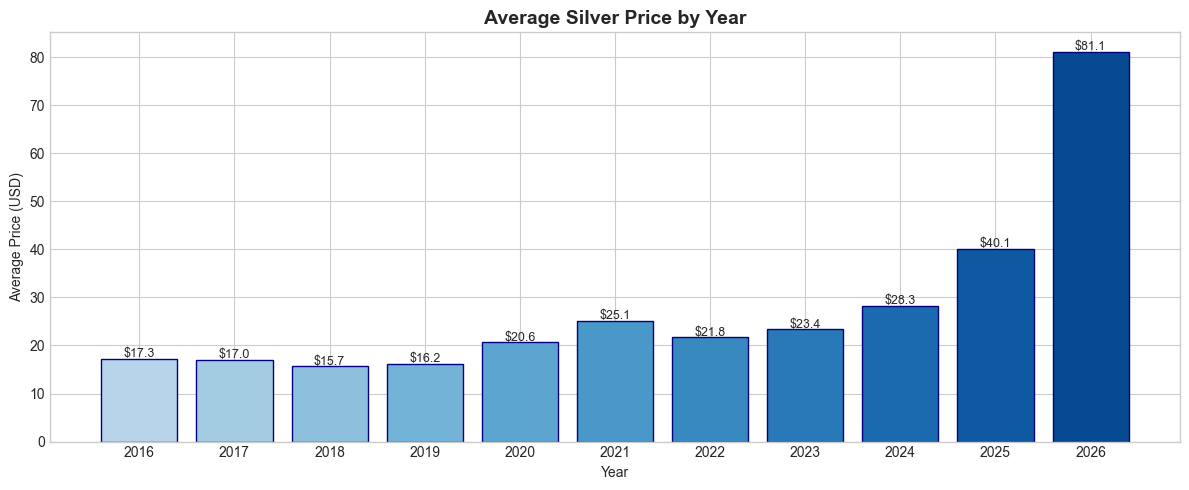

In [17]:
# Yearly Average Price Bar Chart
fig, ax = plt.subplots(figsize=(12, 5))
colors = plt.cm.Blues(np.linspace(0.3, 0.9, len(yearly_stats)))
bars = ax.bar(yearly_stats.index.astype(str), yearly_stats['Avg Price'], color=colors, edgecolor='navy')
ax.set_title('Average Silver Price by Year', fontsize=14, fontweight='bold')
ax.set_xlabel('Year')
ax.set_ylabel('Average Price (USD)')
for bar, val in zip(bars, yearly_stats['Avg Price']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, f'${val:.1f}', ha='center', fontsize=9)
plt.tight_layout()
plt.show()

Time Series Analysis

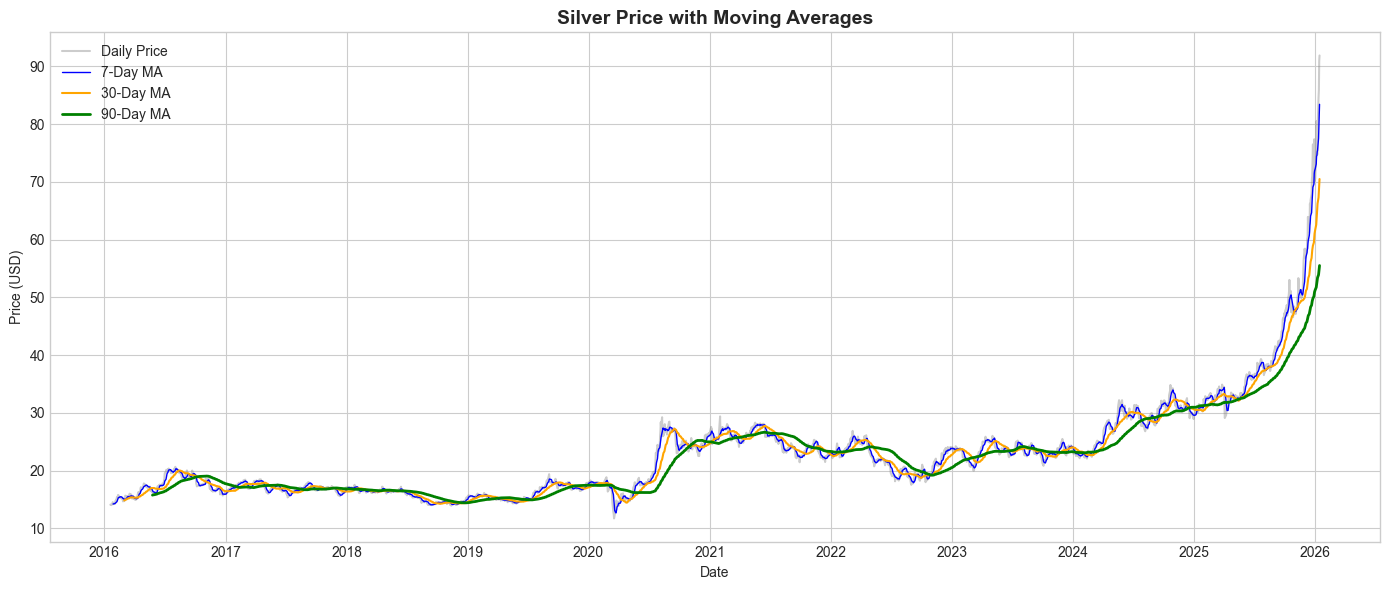

In [18]:
# Moving Averages
df['MA_7'] = df['Price'].rolling(window=7).mean()
df['MA_30'] = df['Price'].rolling(window=30).mean()
df['MA_90'] = df['Price'].rolling(window=90).mean()
df['MA_365'] = df['Price'].rolling(window=365).mean()

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(df.index, df['Price'], alpha=0.4, label='Daily Price', color='gray')
ax.plot(df.index, df['MA_7'], label='7-Day MA', color='blue', linewidth=1)
ax.plot(df.index, df['MA_30'], label='30-Day MA', color='orange', linewidth=1.5)
ax.plot(df.index, df['MA_90'], label='90-Day MA', color='green', linewidth=2)
ax.set_title('Silver Price with Moving Averages', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.tight_layout()
plt.show()

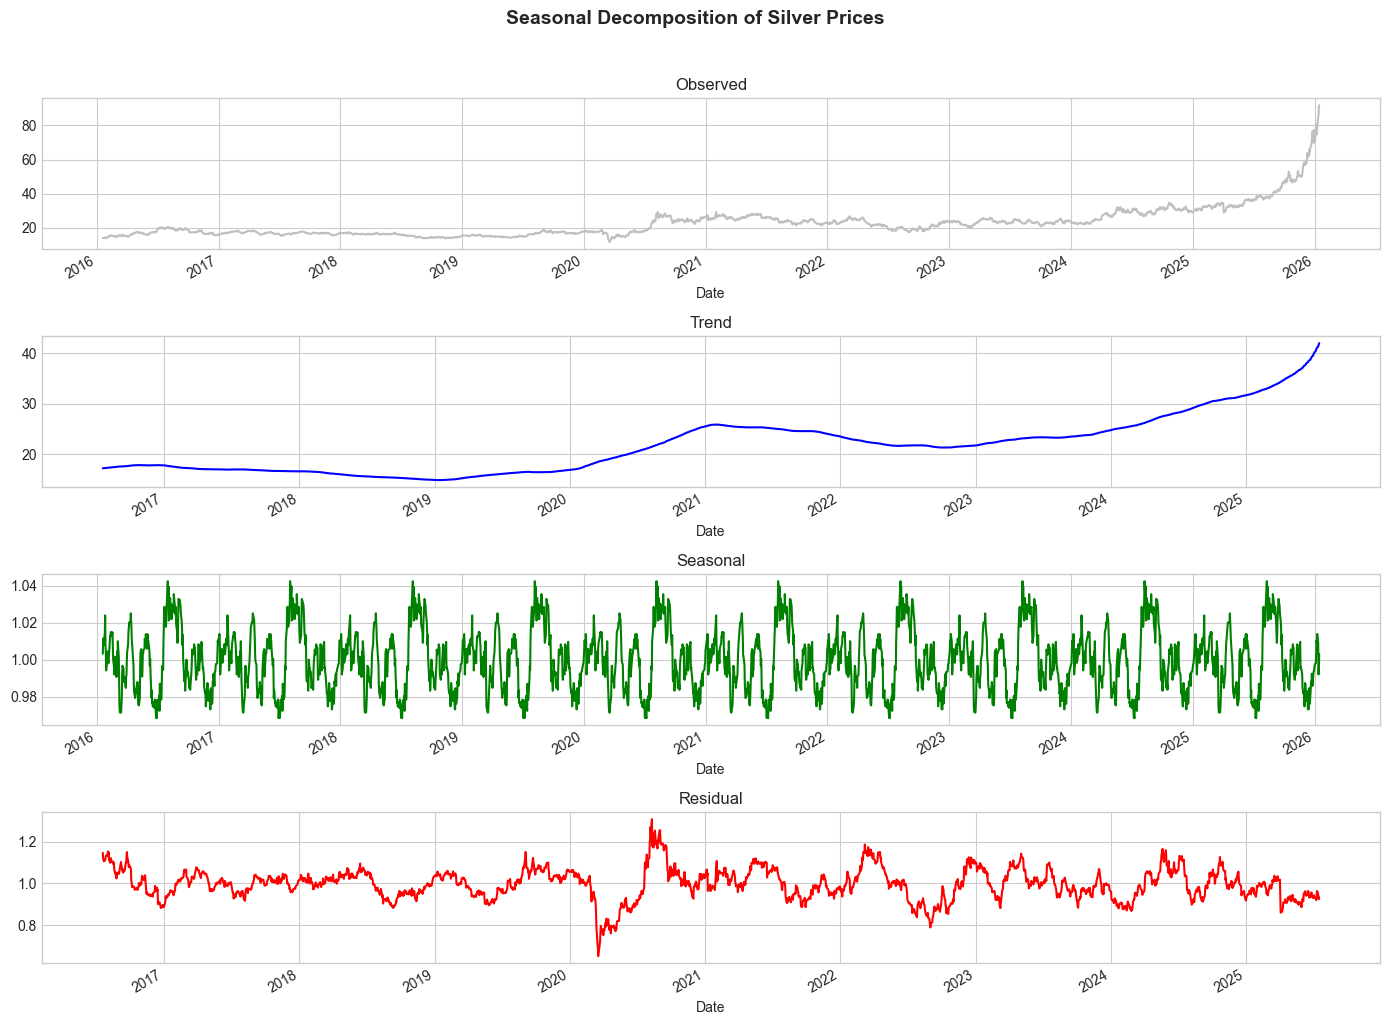

In [19]:
# Seasonal Decomposition
decomposition = seasonal_decompose(df['Price'].dropna(), model='multiplicative', period=252)

fig, axes = plt.subplots(4, 1, figsize=(14, 10))
decomposition.observed.plot(ax=axes[0], title='Observed', color='silver')
decomposition.trend.plot(ax=axes[1], title='Trend', color='blue')
decomposition.seasonal.plot(ax=axes[2], title='Seasonal', color='green')
decomposition.resid.plot(ax=axes[3], title='Residual', color='red')
plt.suptitle('Seasonal Decomposition of Silver Prices', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [20]:
# Stationarity Test (ADF)
result = adfuller(df['Price'].dropna())
print('Augmented Dickey-Fuller Test:')
print(f'   ADF Statistic: {result[0]:.4f}')
print(f'   p-value: {result[1]:.4f}')
print(f'   Critical Values:')
for key, value in result[4].items():
    print(f'      {key}: {value:.4f}')
print(f'\n   Series is {"stationary" if result[1] < 0.05 else "non-stationary"}')

Augmented Dickey-Fuller Test:
   ADF Statistic: 5.2203
   p-value: 1.0000
   Critical Values:
      1%: -3.4330
      5%: -2.8627
      10%: -2.5674

   Series is non-stationary


Feature Engineering

In [21]:
# Create Features
df['Daily_Return'] = df['Price'].pct_change() * 100
df['Volatility_7d'] = df['Daily_Return'].rolling(7).std()
df['Volatility_30d'] = df['Daily_Return'].rolling(30).std()
df['Price_Range'] = df['High'] - df['Low']
df['Month'] = df.index.month
df['DayOfWeek'] = df.index.dayofweek
df['Quarter'] = df.index.quarter

# Lag Features
for lag in [1, 7, 14, 30]:
    df[f'Price_Lag_{lag}'] = df['Price'].shift(lag)

print('Feature Engineering Complete!')
print(f'Total Features: {len(df.columns)}')
df.head()

Feature Engineering Complete!
Total Features: 21


,Price,Close,High,Low,Open,Year,MA_7,MA_30,MA_90,MA_365,...,Volatility_7d,Volatility_30d,Price_Range,Month,DayOfWeek,Quarter,Price_Lag_1,Price_Lag_7,Price_Lag_14,Price_Lag_30
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-19,14.110,14.110,14.065,14.065,3,2016,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000,1,1,1,NaN,NaN,NaN,NaN
2016-01-20,14.147,14.147,14.147,14.147,1,2016,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000,1,2,1,14.110,NaN,NaN,NaN
2016-01-21,14.083,14.083,14.083,14.083,2,2016,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000,1,3,1,14.147,NaN,NaN,NaN
2016-01-22,14.043,14.290,14.043,14.290,7,2016,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.247,1,4,1,14.083,NaN,NaN,NaN
2016-01-25,14.240,14.240,14.095,14.095,8,2016,NaN,NaN,NaN,NaN,...,NaN,NaN,0.000,1,0,1,14.043,NaN,NaN,NaN


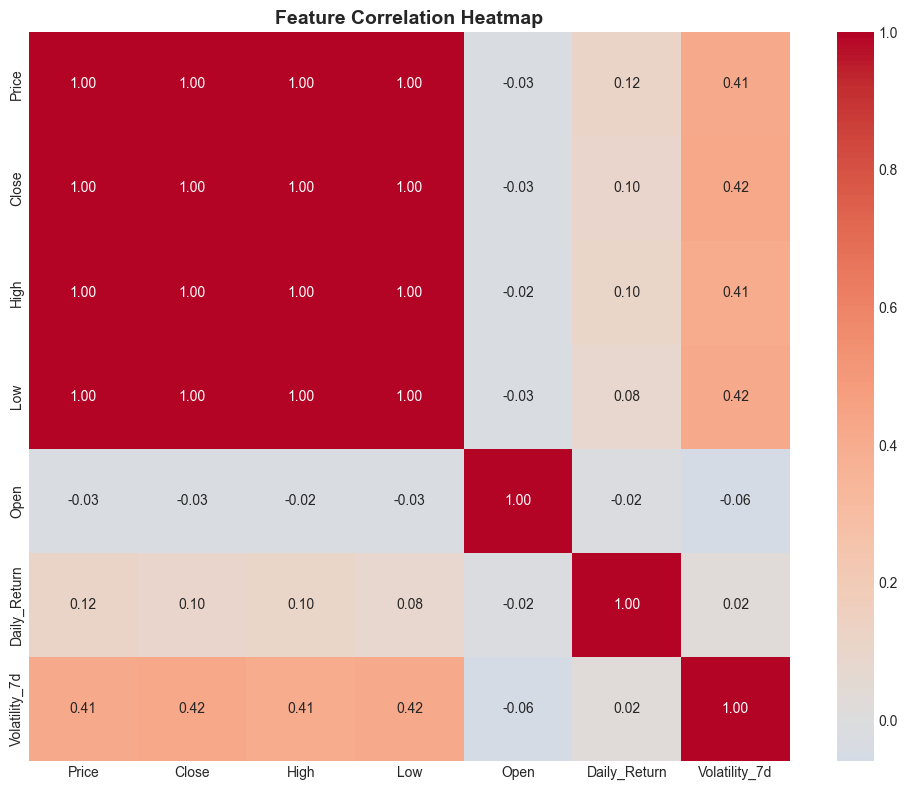

In [22]:
# Correlation Heatmap
corr_cols = ['Price', 'Close', 'High', 'Low', 'Open', 'Daily_Return', 'Volatility_7d']
corr_matrix = df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f', ax=ax)
ax.set_title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Machine Learning Forecasting

In [23]:
# Prepare data for Prophet
prophet_df = df[['Price']].reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df = prophet_df.dropna()

# Train-test split
train_size = int(len(prophet_df) * 0.8)
train = prophet_df[:train_size]
test = prophet_df[train_size:]

print(f'Training samples: {len(train)}')
print(f'Testing samples: {len(test)}')

Training samples: 2010
Testing samples: 503


In [24]:
# Train Prophet Model
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)
model.fit(train)
print('Prophet model trained successfully!')


16:12:12 - cmdstanpy - INFO - Chain [1] start processing
16:12:14 - cmdstanpy - INFO - Chain [1] done processing


Prophet model trained successfully!


In [25]:
# Make predictions on test set
test_forecast = model.predict(test[['ds']])

# Calculate metrics
y_true = test['y'].values
y_pred = test_forecast['yhat'].values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print('Prophet Model Evaluation Metrics:')
print(f'   RMSE: ${rmse:.2f}')
print(f'   MAE:  ${mae:.2f}')
print(f'   MAPE: {mape:.2f}%')
print(f'   R2:   {r2:.4f}')

Prophet Model Evaluation Metrics:
   RMSE: $14.33
   MAE:  $9.78
   MAPE: 23.15%
   R2:   -0.5761


16:12:22 - cmdstanpy - INFO - Chain [1] start processing
16:12:23 - cmdstanpy - INFO - Chain [1] done processing


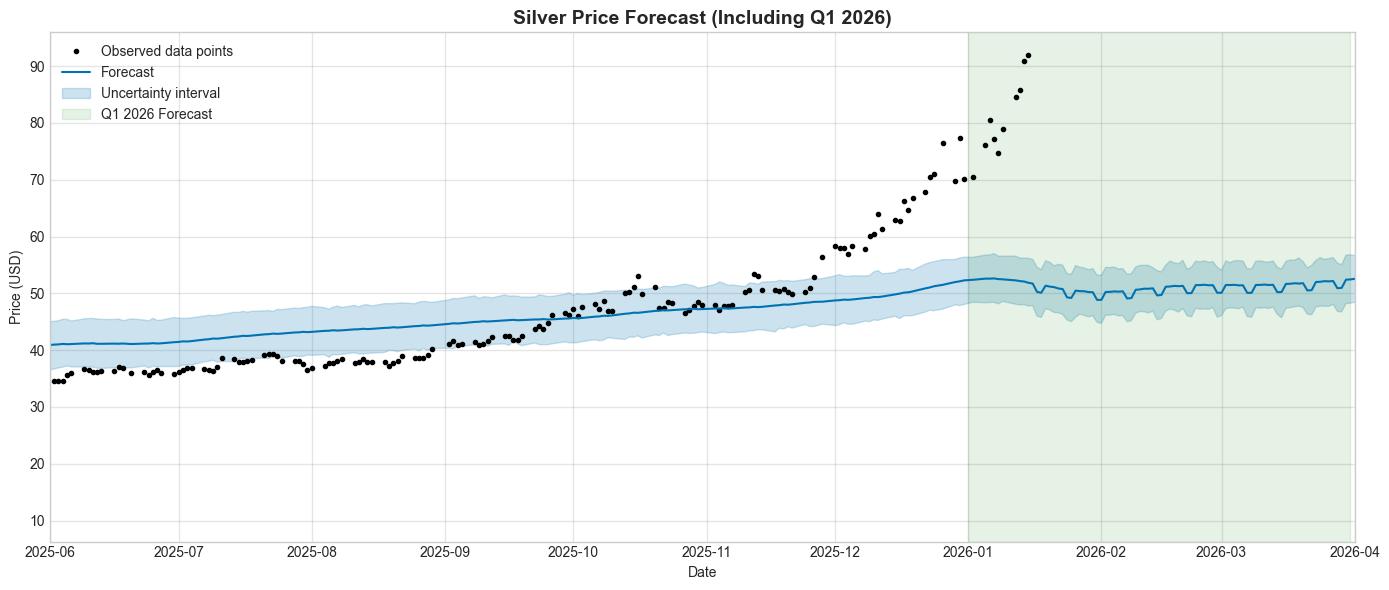

In [26]:
# Retrain on full dataset for future forecast
model_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)
model_full.fit(prophet_df)

# Forecast for Q1 2026 (Jan, Feb, Mar)
future_dates = model_full.make_future_dataframe(periods=90, freq='D') 
forecast = model_full.predict(future_dates)

# Ensure ds is datetime
forecast['ds'] = pd.to_datetime(forecast['ds'])

# Filter for specific Q1 2026 range
start_date = pd.to_datetime('2026-01-01')
end_date = pd.to_datetime('2026-03-31')
forecast_q1_2026 = forecast[(forecast['ds'] >= start_date) & (forecast['ds'] <= end_date)]

# Plot forecast
fig = model_full.plot(forecast, figsize=(14, 6))
plt.title('Silver Price Forecast (Including Q1 2026)', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
# Highlight Q1 2026
plt.axvspan(start_date, end_date, color='green', alpha=0.1, label='Q1 2026 Forecast')
plt.legend()
plt.xlim(pd.to_datetime('2025-06-01'), pd.to_datetime('2026-04-01')) # Zoom in
plt.tight_layout()
plt.show()

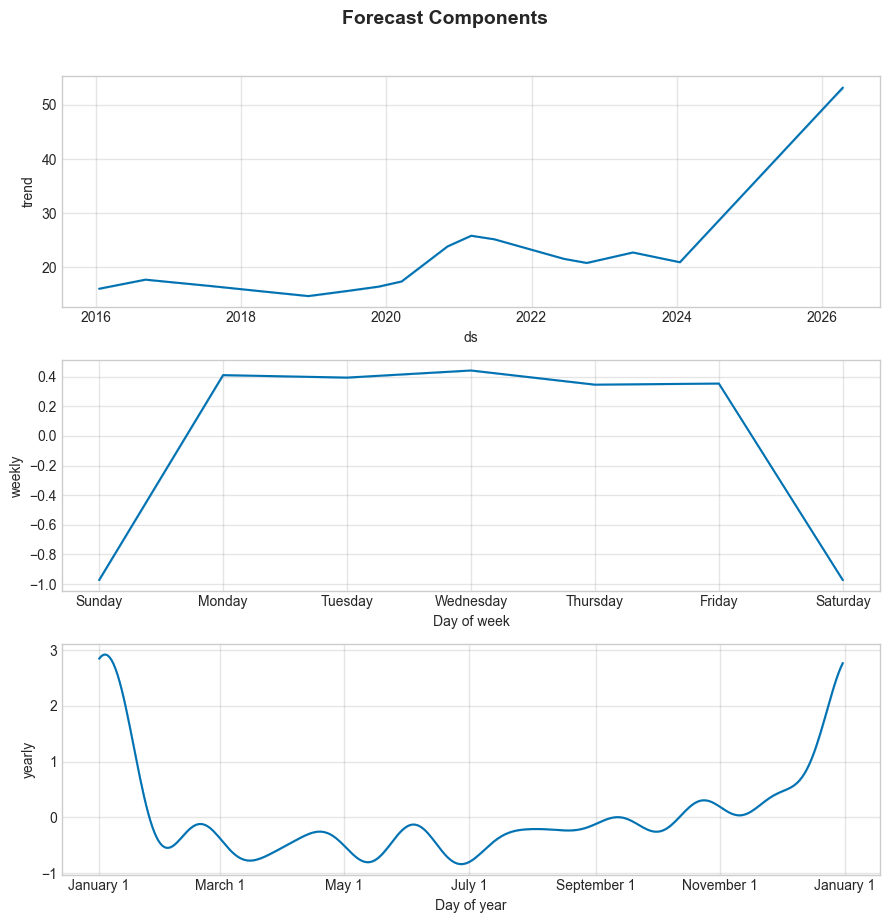

In [27]:
# Plot components
fig = model_full.plot_components(forecast)
plt.suptitle('Forecast Components', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


In [28]:
# Forecast Table for Q1 2026
forecast_export = forecast_q1_2026[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].copy()
forecast_export.columns = ['Date', 'Predicted_Price', 'Lower_Bound', 'Upper_Bound']
forecast_export = forecast_export.round(2)
print('Silver Price Forecast for Q1 2026 (Jan-Mar):')
print(f'Rows: {len(forecast_export)}')
forecast_export.head()

Silver Price Forecast for Q1 2026 (Jan-Mar):
Rows: 85


,Date,Predicted_Price,Lower_Bound,Upper_Bound
2503,2026-01-02,52.38,48.43,56.35
2504,2026-01-05,52.59,48.35,56.73
2505,2026-01-06,52.59,48.39,56.77
2506,2026-01-07,52.63,48.42,56.98
2507,2026-01-08,52.51,48.15,56.54


In [29]:
# Prepare data for Random Forest
features = ['Close', 'High', 'Low', 'Open', 'MA_7', 'MA_30', 'Volatility_7d', 'Month', 'DayOfWeek', 'Price_Lag_1', 'Price_Lag_7']
df_ml = df[features + ['Price']].dropna().copy()
X = df_ml[features]
y = df_ml['Price']

print(f'ML Dataset Shape: {df_ml.shape}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1)
rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_pred = rf_model.predict(X_test_scaled)

# Metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

print('Random Forest Model Evaluation:')
print(f'   RMSE: ${rf_rmse:.2f}')
print(f'   MAE:  ${rf_mae:.2f}')
print(f'   R2:   {rf_r2:.4f}')

ML Dataset Shape: (2484, 12)
Random Forest Model Evaluation:
   RMSE: $13.09
   MAE:  $7.32
   R2:   -0.3190


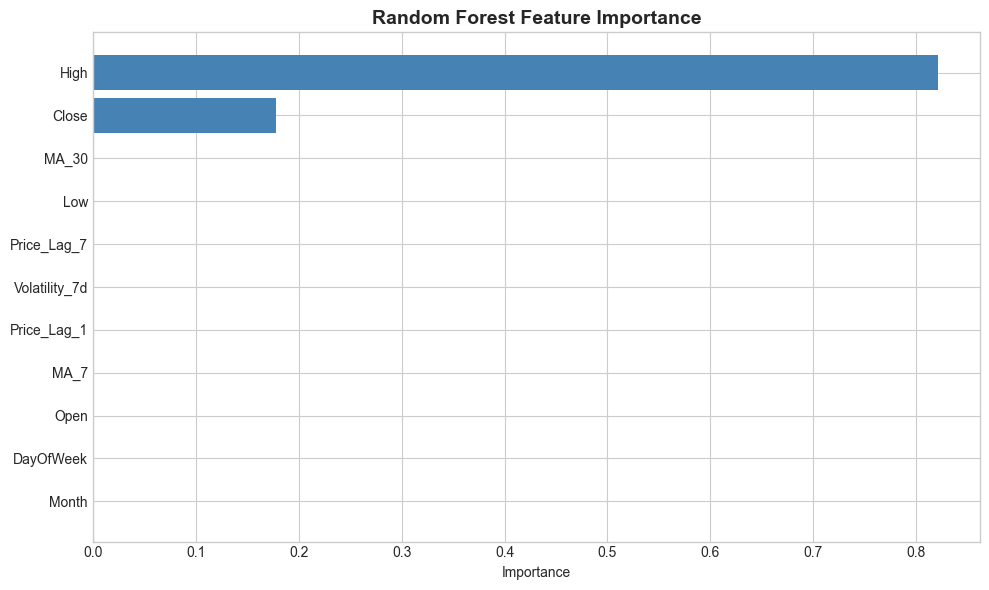

In [30]:
# Feature Importance
importance = pd.DataFrame({'Feature': features, 'Importance': rf_model.feature_importances_})
importance = importance.sort_values('Importance', ascending=True)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(importance['Feature'], importance['Importance'], color='steelblue')
ax.set_title('Random Forest Feature Importance', fontsize=14, fontweight='bold')
ax.set_xlabel('Importance')
plt.tight_layout()
plt.show()

Model Evaluation & Comparison

In [31]:
# Model Comparison Table
comparison = pd.DataFrame({
    'Model': ['Prophet', 'Random Forest'],
    'RMSE ($)': [rmse, rf_rmse],
    'MAE ($)': [mae, rf_mae],
    'R2': [r2, rf_r2]
})
print('Model Comparison:')
comparison.round(4)

Model Comparison:


,Model,RMSE ($),MAE ($),R2
0,Prophet,14.3306,9.7767,-0.5761
1,Random Forest,13.0875,7.3187,-0.3190


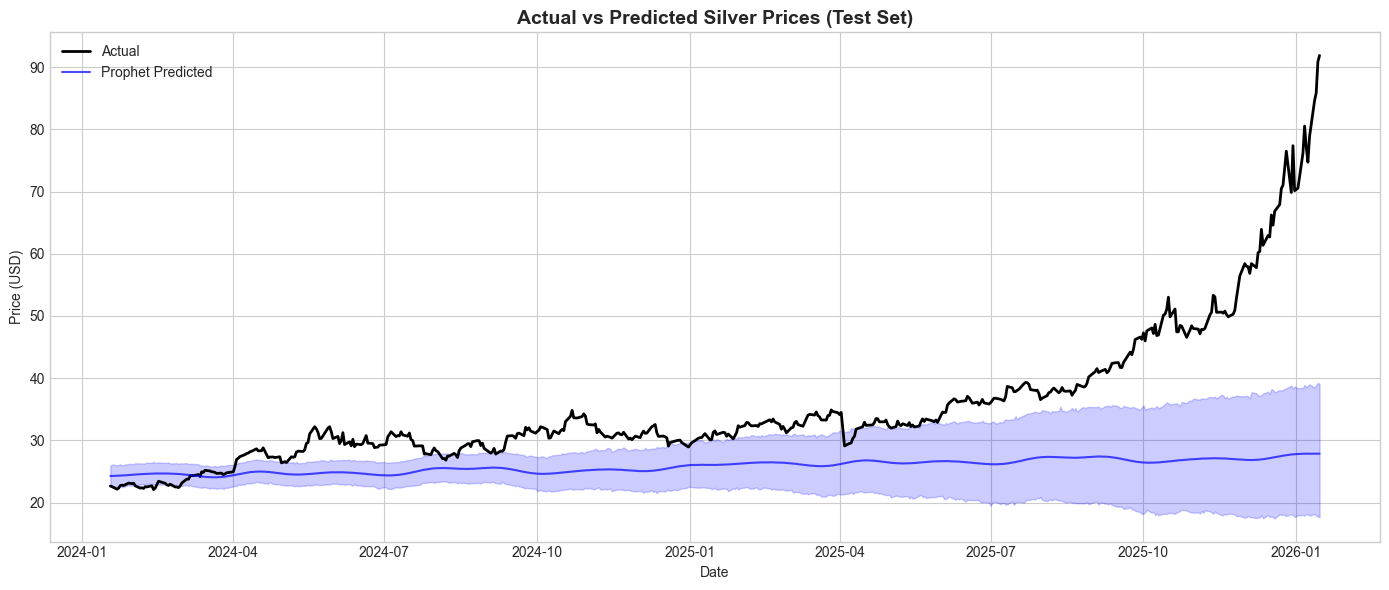

In [32]:
# Actual vs Predicted Plot
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test['ds'].values, y_true, label='Actual', color='black', linewidth=2)
ax.plot(test['ds'].values, y_pred, label='Prophet Predicted', color='blue', alpha=0.7)
ax.fill_between(test['ds'].values, test_forecast['yhat_lower'].values, test_forecast['yhat_upper'].values, alpha=0.2, color='blue')
ax.set_title('Actual vs Predicted Silver Prices (Test Set)', fontsize=14, fontweight='bold')
ax.set_xlabel('Date')
ax.set_ylabel('Price (USD)')
ax.legend()
plt.tight_layout()
plt.show()

Market Analysis & Future Projections

In [33]:
# Monthly Forecast Summary 2026
forecast_q1_2026['Month'] = forecast_q1_2026['ds'].dt.month_name()
monthly_forecast = forecast_q1_2026.groupby('Month')['yhat'].agg(['mean', 'min', 'max']).round(2)
monthly_forecast.columns = ['Avg Price', 'Min Price', 'Max Price']
monthly_forecast = monthly_forecast.reindex(['January', 'February', 'March'])
print('Monthly Price Forecast for Q1 2026:')
monthly_forecast

Monthly Price Forecast for Q1 2026:


,Avg Price,Min Price,Max Price
Month,,,
January,51.15,48.86,52.63
February,50.56,48.86,51.52
March,51.37,50.09,52.45


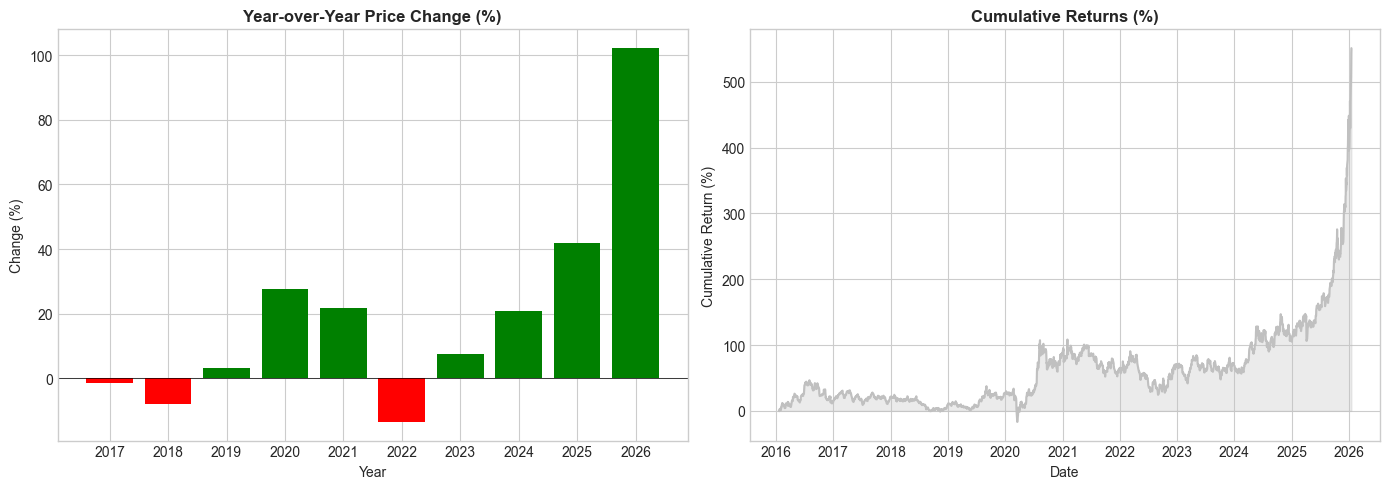

In [34]:
# Calculate YoY growth
yearly_avg = df.groupby('Year')['Price'].mean()
yoy_growth = yearly_avg.pct_change() * 100

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# YoY Growth
colors = ['green' if x > 0 else 'red' for x in yoy_growth.dropna()]
axes[0].bar(yoy_growth.dropna().index.astype(str), yoy_growth.dropna(), color=colors)
axes[0].set_title('Year-over-Year Price Change (%)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Change (%)')
axes[0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Cumulative Returns
cumulative_returns = (1 + df['Daily_Return']/100).cumprod() - 1
axes[1].plot(df.index, cumulative_returns * 100, color='silver', linewidth=1.5)
axes[1].fill_between(df.index, cumulative_returns * 100, alpha=0.3, color='silver')
axes[1].set_title('Cumulative Returns (%)', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Cumulative Return (%)')

plt.tight_layout()
plt.show()

Conclusions

In [35]:
# Save forecast to CSV (Jan-Mar 2026 Only)
forecast_export.to_csv('silver_price_forecast_2026.csv', index=False)
print('Forecast saved to silver_price_forecast_2026.csv (Jan-Mar 2026 Only)')

Forecast saved to silver_price_forecast_2026.csv (Jan-Mar 2026 Only)
